In [19]:
%%capture
!pip install skforecast

In [20]:
%%capture
!pip install sktime

In [21]:
# Libraries
# ==============================================================================
import os
#os.environ["KERAS_BACKEND"] = "torch" # 'tensorflow', 'jax´ or 'torch'
os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('once')

print(f"skforecast version: {skforecast.__version__}")
print(f"keras version: {keras.__version__}")

if keras.__version__ > "3.0":
    print(f"Using backend: {keras.backend.backend()}")
    if keras.backend.backend() == "tensorflow":
        import tensorflow
        print(f"tensorflow version: {tensorflow.__version__}")
    elif keras.backend.backend() == "torch":
        import torch
        print(f"torch version: {torch.__version__}")
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

skforecast version: 0.13.0
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.17.0


In [32]:
# Data download
# ==============================================================================
air_quality = fetch_dataset(name="air_quality_valencia")

# Data preparation
# ==============================================================================
air_quality = air_quality.interpolate(method="linear")
air_quality = air_quality.sort_index()
air_quality.head()

air_quality_valencia
--------------------
Hourly measures of several air chemical pollutant (pm2.5, co, no, no2, pm10,
nox, o3, so2) at Valencia city.
 Red de Vigilancia y Control de la Contaminación Atmosférica, 46250054-València
- Centre, https://mediambient.gva.es/es/web/calidad-ambiental/datos-historicos.
Shape of the dataset: (26304, 10)


,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0


In [33]:
air_quality

,pm2.5,co,no,no2,pm10,nox,o3,veloc.,direc.,so2
datetime,,,,,,,,,,
2019-01-01 00:00:00,19.0,0.2,3.0,36.0,22.0,40.0,16.0,0.5,262.0,8.0
2019-01-01 01:00:00,26.0,0.1,2.0,40.0,32.0,44.0,6.0,0.6,248.0,8.0
2019-01-01 02:00:00,31.0,0.1,11.0,42.0,36.0,58.0,3.0,0.3,224.0,8.0
2019-01-01 03:00:00,30.0,0.1,15.0,41.0,35.0,63.0,3.0,0.2,220.0,10.0
2019-01-01 04:00:00,30.0,0.1,16.0,39.0,36.0,63.0,3.0,0.4,221.0,11.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,31.0,0.1,20.0,36.0,34.0,66.0,13.0,0.1,87.0,3.0
2021-12-31 20:00:00,33.0,0.1,25.0,38.0,39.0,75.0,13.0,0.1,67.0,4.0
2021-12-31 21:00:00,34.0,0.1,24.0,36.0,42.0,73.0,13.0,0.1,84.0,5.0


In [34]:
# Checking the frequency of the time series
# ==============================================================================
print(f"Index: {air_quality.index.dtype}")
print(f"Frequency: {air_quality.index.freq}")

Index: datetime64[ns]
Frequency: <Hour>


In [35]:
# Split train-validation-test
# ==============================================================================
end_train = "2021-03-31 23:59:00"
end_validation = "2021-09-30 23:59:00"
air_quality_train = air_quality.loc[:end_train, :].copy()
air_quality_val = air_quality.loc[end_train:end_validation, :].copy()
air_quality_test = air_quality.loc[end_validation:, :].copy()

print(
    f"Dates train      : {air_quality_train.index.min()} --- " 
    f"{air_quality_train.index.max()}  (n={len(air_quality_train)})"
)
print(
    f"Dates validation : {air_quality_val.index.min()} --- " 
    f"{air_quality_val.index.max()}  (n={len(air_quality_val)})"
)
print(
    f"Dates test       : {air_quality_test.index.min()} --- " 
    f"{air_quality_test.index.max()}  (n={len(air_quality_test)})"
)

Dates train      : 2019-01-01 00:00:00 --- 2021-03-31 23:00:00  (n=19704)
Dates validation : 2021-04-01 00:00:00 --- 2021-09-30 23:00:00  (n=4392)
Dates test       : 2021-10-01 00:00:00 --- 2021-12-31 23:00:00  (n=2208)


In [36]:
air_quality_train['o3']

datetime
2019-01-01 00:00:00    16.0
2019-01-01 01:00:00     6.0
2019-01-01 02:00:00     3.0
2019-01-01 03:00:00     3.0
2019-01-01 04:00:00     3.0
                       ... 
2021-03-31 19:00:00    80.0
2021-03-31 20:00:00    77.0
2021-03-31 21:00:00    71.0
2021-03-31 22:00:00    59.0
2021-03-31 23:00:00    50.0
Freq: h, Name: o3, Length: 19704, dtype: float64

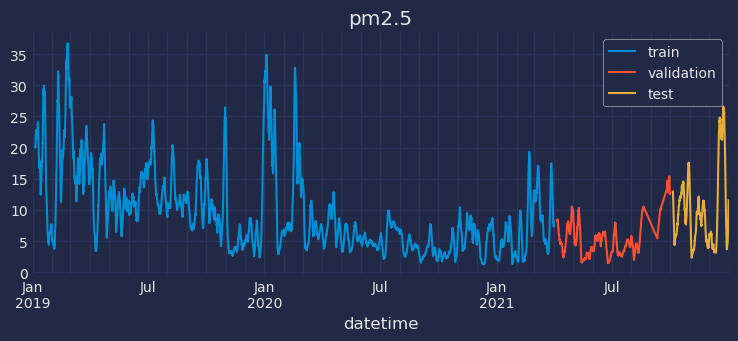

In [37]:
# Plotting one feature
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(8, 3))
air_quality_train["pm2.5"].rolling(100).mean().plot(ax=ax, label="train")
air_quality_val["pm2.5"].rolling(100).mean().plot(ax=ax, label="validation")
air_quality_test["pm2.5"].rolling(100).mean().plot(ax=ax, label="test")
ax.set_title("pm2.5")
ax.legend();

# Multi Step Univariate

In [39]:
# Model creation
# ==============================================================================
# Model creation
# ==============================================================================
series = ["o3"] # Series used as predictors
levels = ["o3"] # Target serie to predict
lags = 32 # Past time steps to be used to predict the target
steps = 5 # Future time steps to be predicted

model = create_and_compile_model(
    series=data_train,
    levels=levels, 
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=50,
    dense_units=32,
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

NameError: name 'data_train' is not defined

In [18]:
# Forecaster Creation
# ==============================================================================
forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 32,  # Batch size to train the model.
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=5)
        ],  # Callback to stop training when it is no longer learning.
        "series_val": data_val,  # Validation data for model training.
    },
)    



NameError: name 'model' is not defined

In [21]:
# Fit forecaster
# ==============================================================================
forecaster.fit(data_train)

Epoch 1/3
615/615 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0507 - val_loss: 0.0218
Epoch 2/3
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0158 - val_loss: 0.0124
Epoch 3/3
615/615 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0123 - val_loss: 0.0120


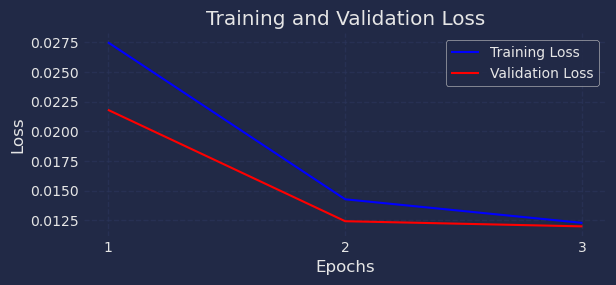

In [22]:
# Train and overfitting tracking
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
forecaster.plot_history(ax=ax)

In [23]:
# Prediction
# ==============================================================================
predictions = forecaster.predict()
predictions

,o3
2021-04-01 00:00:00,48.177692
2021-04-01 01:00:00,43.115685
2021-04-01 02:00:00,35.760845
2021-04-01 03:00:00,34.342926
2021-04-01 04:00:00,32.148907


In [26]:
# Specific step predictions
# ==============================================================================
predictions = forecaster.predict(steps=[1, 3])
predictions

,o3
2021-04-01 00:00:00,48.177692
2021-04-01 02:00:00,35.760845


In [27]:
# Backtesting 
# ==============================================================================
metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_validation, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)

Epoch 1/3
752/752 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0123 - val_loss: 0.0117
Epoch 2/3
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 3/3
752/752 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0118 - val_loss: 0.0116


  0%|          | 0/442 [00:00<?, ?it/s]

In [28]:
# Backtesting predictions
# ==============================================================================
predictions

,o3
2021-10-01 00:00:00,50.096142
2021-10-01 01:00:00,50.902096
2021-10-01 02:00:00,49.854034
2021-10-01 03:00:00,48.157284
2021-10-01 04:00:00,45.637589
...,...
2021-12-31 19:00:00,25.431969
2021-12-31 20:00:00,22.087345
2021-12-31 21:00:00,14.413236
2021-12-31 22:00:00,14.864934


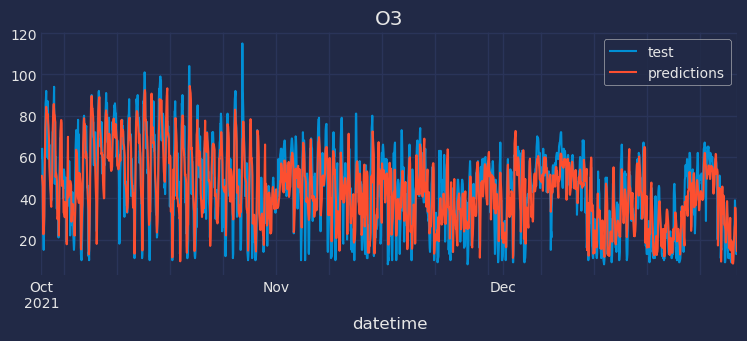

In [29]:
# Plotting predictions vs real values in the test set
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
data_test["o3"].plot(ax=ax, label="test")
predictions["o3"].plot(ax=ax, label="predictions")
ax.set_title("O3")
ax.legend();

In [30]:
# Backtesting metrics
# ==============================================================================
metrics

,levels,mean_absolute_error
0,o3,9.618303


In [31]:
# % Error vs series mean
# ==============================================================================
rel_mse = 100 * metrics.loc[0, 'mean_absolute_error'] / np.mean(data["o3"])
print(f"Serie mean: {np.mean(data['o3']):0.2f}")
print(f"Relative error (mae): {rel_mse:0.2f} %")

Serie mean: 54.52
Relative error (mae): 17.64 %
